# Attachment

In [1]:
import pandas as pd
from datetime import datetime 
import numpy as np
import matplotlib.pyplot as plt
import requests
import pyodbc
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from scipy.stats import zscore
from scipy.stats.mstats import winsorize


# PIPELINE

In [2]:
# define the path to your data file here
data_file = "C:/Advance Substation Forecasting/Active1.csv"

# define your data ingestion function here
def ingest_data(data_file):
    # read the data file into a pandas DataFrame
    df = pd.read_csv(data_file)
    return df

# ingest the data
df = ingest_data(data_file)
# show the loaded dataframe
df


,DATE,TIME,VOLTAGE,CURRENT,PF,POWER (KW),"""WEEKEND/WEEKDAY""",SEASON,Temp (F),Humidity (%),Substation Shutdown,F1,F2,F3,F4,Jul-Oct-,Rainy,0
0,01-01-2021,01:00:00,11.6,102,0.96,1967,0,1,65,90,NaN,NaN,NaN,NaN,NaN,Nov-Feb,Winter,1.0
1,NaN,02:00:00,11.6,102,0.96,1967,0,1,65,90,NaN,NaN,NaN,NaN,NaN,Mar-Jun,Summer,2.0
2,NaN,03:00:00,11.6,102,0.96,1967,0,1,65,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,04:00:00,11.3,130,0.96,2443,0,1,78,49,NaN,NaN,NaN,NaN,NaN,Weekend,1,NaN
4,NaN,05:00:00,11.2,148,0.96,2756,0,1,78,49,NaN,NaN,NaN,NaN,NaN,Weekday,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,NaN,20:00:00,11.6,64,0.95,1222,0,1,67,92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8756,NaN,21:00:00,11.5,62,0.95,1173,0,1,67,92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8757,NaN,22:00:00,11.5,57,0.95,1079,0,1,65,94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8758,NaN,23:00:00,11.5,48,0.95,908,0,1,65,94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Preprocessing

In [3]:
df['DATE'].fillna(method='ffill', inplace=True)
df

,DATE,TIME,VOLTAGE,CURRENT,PF,POWER (KW),"""WEEKEND/WEEKDAY""",SEASON,Temp (F),Humidity (%),Substation Shutdown,F1,F2,F3,F4,Jul-Oct-,Rainy,0
0,01-01-2021,01:00:00,11.6,102,0.96,1967,0,1,65,90,NaN,NaN,NaN,NaN,NaN,Nov-Feb,Winter,1.0
1,01-01-2021,02:00:00,11.6,102,0.96,1967,0,1,65,90,NaN,NaN,NaN,NaN,NaN,Mar-Jun,Summer,2.0
2,01-01-2021,03:00:00,11.6,102,0.96,1967,0,1,65,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01-01-2021,04:00:00,11.3,130,0.96,2443,0,1,78,49,NaN,NaN,NaN,NaN,NaN,Weekend,1,NaN
4,01-01-2021,05:00:00,11.2,148,0.96,2756,0,1,78,49,NaN,NaN,NaN,NaN,NaN,Weekday,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,31-12-2021,20:00:00,11.6,64,0.95,1222,0,1,67,92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8756,31-12-2021,21:00:00,11.5,62,0.95,1173,0,1,67,92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8757,31-12-2021,22:00:00,11.5,57,0.95,1079,0,1,65,94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8758,31-12-2021,23:00:00,11.5,48,0.95,908,0,1,65,94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df['datetime'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'])
df

,DATE,TIME,VOLTAGE,CURRENT,PF,POWER (KW),"""WEEKEND/WEEKDAY""",SEASON,Temp (F),Humidity (%),Substation Shutdown,F1,F2,F3,F4,Jul-Oct-,Rainy,0,datetime
0,01-01-2021,01:00:00,11.6,102,0.96,1967,0,1,65,90,NaN,NaN,NaN,NaN,NaN,Nov-Feb,Winter,1.0,2021-01-01 01:00:00
1,01-01-2021,02:00:00,11.6,102,0.96,1967,0,1,65,90,NaN,NaN,NaN,NaN,NaN,Mar-Jun,Summer,2.0,2021-01-01 02:00:00
2,01-01-2021,03:00:00,11.6,102,0.96,1967,0,1,65,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-01 03:00:00
3,01-01-2021,04:00:00,11.3,130,0.96,2443,0,1,78,49,NaN,NaN,NaN,NaN,NaN,Weekend,1,NaN,2021-01-01 04:00:00
4,01-01-2021,05:00:00,11.2,148,0.96,2756,0,1,78,49,NaN,NaN,NaN,NaN,NaN,Weekday,0,NaN,2021-01-01 05:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,31-12-2021,20:00:00,11.6,64,0.95,1222,0,1,67,92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 20:00:00
8756,31-12-2021,21:00:00,11.5,62,0.95,1173,0,1,67,92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 21:00:00
8757,31-12-2021,22:00:00,11.5,57,0.95,1079,0,1,65,94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 22:00:00
8758,31-12-2021,23:00:00,11.5,48,0.95,908,0,1,65,94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 23:00:00


In [5]:
df.dtypes

DATE                           object
TIME                           object
VOLTAGE                       float64
CURRENT                         int64
PF                            float64
POWER (KW)                      int64
"WEEKEND/WEEKDAY"               int64
SEASON                          int64
Temp (F)                        int64
Humidity (%)                    int64
Substation Shutdown           float64
F1                            float64
F2                            float64
F3                            float64
F4                            float64
Jul-Oct-                       object
Rainy                          object
0                             float64
datetime               datetime64[ns]
dtype: object

In [6]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%d-%m-%Y %H:%M:%S')

In [7]:
df.dtypes

DATE                           object
TIME                           object
VOLTAGE                       float64
CURRENT                         int64
PF                            float64
POWER (KW)                      int64
"WEEKEND/WEEKDAY"               int64
SEASON                          int64
Temp (F)                        int64
Humidity (%)                    int64
Substation Shutdown           float64
F1                            float64
F2                            float64
F3                            float64
F4                            float64
Jul-Oct-                       object
Rainy                          object
0                             float64
datetime               datetime64[ns]
dtype: object

In [8]:
df.index = pd.to_datetime(df['datetime'])
df

,DATE,TIME,VOLTAGE,CURRENT,PF,POWER (KW),"""WEEKEND/WEEKDAY""",SEASON,Temp (F),Humidity (%),Substation Shutdown,F1,F2,F3,F4,Jul-Oct-,Rainy,0,datetime
datetime,,,,,,,,,,,,,,,,,,,
2021-01-01 01:00:00,01-01-2021,01:00:00,11.6,102,0.96,1967,0,1,65,90,NaN,NaN,NaN,NaN,NaN,Nov-Feb,Winter,1.0,2021-01-01 01:00:00
2021-01-01 02:00:00,01-01-2021,02:00:00,11.6,102,0.96,1967,0,1,65,90,NaN,NaN,NaN,NaN,NaN,Mar-Jun,Summer,2.0,2021-01-01 02:00:00
2021-01-01 03:00:00,01-01-2021,03:00:00,11.6,102,0.96,1967,0,1,65,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-01 03:00:00
2021-01-01 04:00:00,01-01-2021,04:00:00,11.3,130,0.96,2443,0,1,78,49,NaN,NaN,NaN,NaN,NaN,Weekend,1,NaN,2021-01-01 04:00:00
2021-01-01 05:00:00,01-01-2021,05:00:00,11.2,148,0.96,2756,0,1,78,49,NaN,NaN,NaN,NaN,NaN,Weekday,0,NaN,2021-01-01 05:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 20:00:00,31-12-2021,20:00:00,11.6,64,0.95,1222,0,1,67,92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 20:00:00
2021-12-31 21:00:00,31-12-2021,21:00:00,11.5,62,0.95,1173,0,1,67,92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 21:00:00
2021-12-31 22:00:00,31-12-2021,22:00:00,11.5,57,0.95,1079,0,1,65,94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 22:00:00


In [9]:
df.columns

Index(['DATE', 'TIME', 'VOLTAGE', 'CURRENT', 'PF', 'POWER (KW)',
       '"WEEKEND/WEEKDAY"', 'SEASON', 'Temp (F)', 'Humidity (%)',
       'Substation Shutdown', 'F1', 'F2', 'F3', 'F4', 'Jul-Oct-', 'Rainy', '0',
       'datetime'],
      dtype='object')

In [10]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


In [11]:
skewness = df.skew()
print(skewness)

VOLTAGE               -0.357412
CURRENT                0.889695
PF                    -1.237982
POWER (KW)             0.889583
"WEEKEND/WEEKDAY"      2.046167
SEASON                 0.005051
Temp (F)              -0.041463
Humidity (%)          -0.550443
Substation Shutdown    0.000000
F1                     0.000000
F2                     0.000000
F3                     0.000000
F4                     0.000000
0                           NaN
dtype: float64


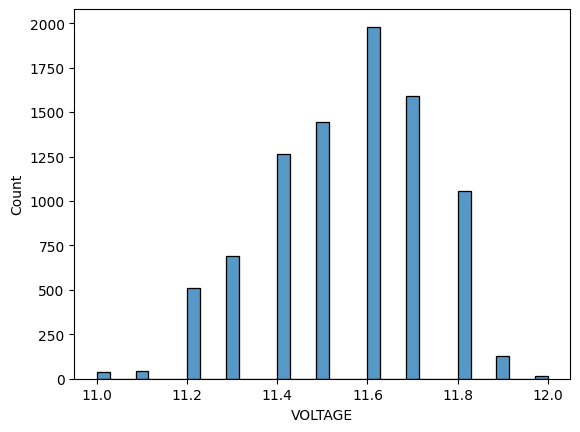

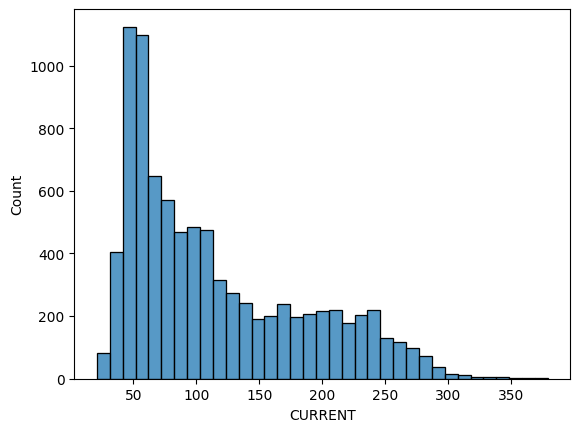

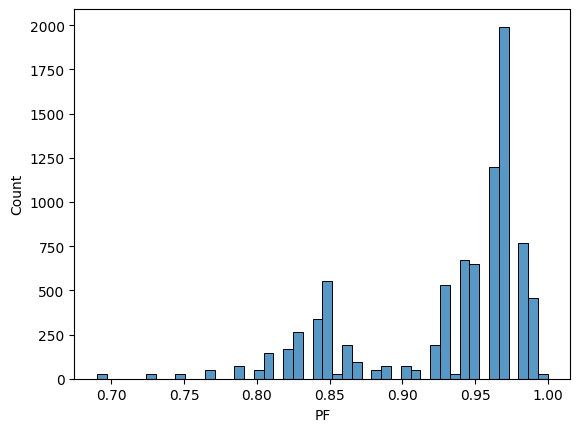

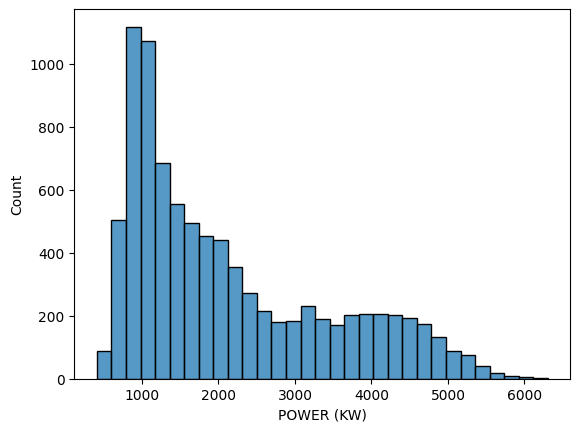

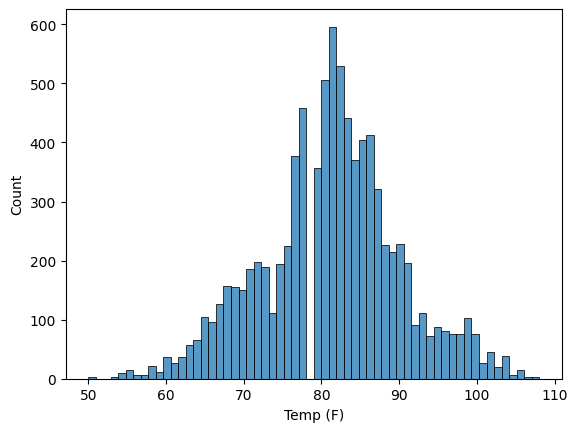

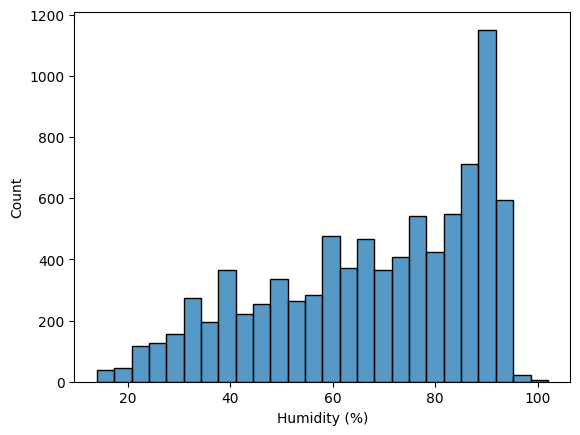

In [12]:
sns.histplot(df["VOLTAGE"])
plt.show()
sns.histplot(df["CURRENT"])
plt.show()
sns.histplot(df["PF"])
plt.show()
sns.histplot(df["POWER (KW)"])
plt.show()
sns.histplot(df["Temp (F)"])
plt.show()
sns.histplot(df["Humidity (%)"])
plt.show()

# Outlier Detection

In [13]:
for col in df.columns:
    if col != "DATE" and col != "TIME" and col != "WEEKEND/WEEKDAY" and col !="Jul-Oct-" and col !="Rainy" and col != "SEASON":
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        upper_fence = q3 + (1.5 * iqr)
        lower_fence = q1 - (1.5 * iqr)
        outliers = df[(df[col] < lower_fence) | (df[col] > upper_fence)]
        if len(outliers) > 0:
            print("Outliers in " + col)
            print(outliers)
            print()

Outliers in CURRENT
                           DATE      TIME  VOLTAGE  CURRENT     PF  \
datetime                                                             
2021-02-03 16:00:00  02-03-2021  16:00:00     11.2      327  0.960   
2021-05-08 09:00:00  05-08-2021  09:00:00     11.6      332  0.860   
2021-05-08 13:00:00  05-08-2021  13:00:00     11.7      325  0.860   
2021-05-08 14:00:00  05-08-2021  14:00:00     11.6      341  0.860   
2021-05-08 15:00:00  05-08-2021  15:00:00     11.8      342  0.860   
2021-08-08 11:00:00  08-08-2021  11:00:00     11.5      329  0.840   
2021-08-08 12:00:00  08-08-2021  12:00:00     11.7      329  0.840   
2021-12-08 08:00:00  12-08-2021  08:00:00     11.5      334  0.840   
2021-12-08 09:00:00  12-08-2021  09:00:00     11.2      339  0.840   
2021-12-08 10:00:00  12-08-2021  10:00:00     11.2      344  0.840   
2021-12-08 12:00:00  12-08-2021  12:00:00     11.2      336  0.840   
2021-08-13 08:00:00  13-08-2021  08:00:00     11.1      379  0.850   


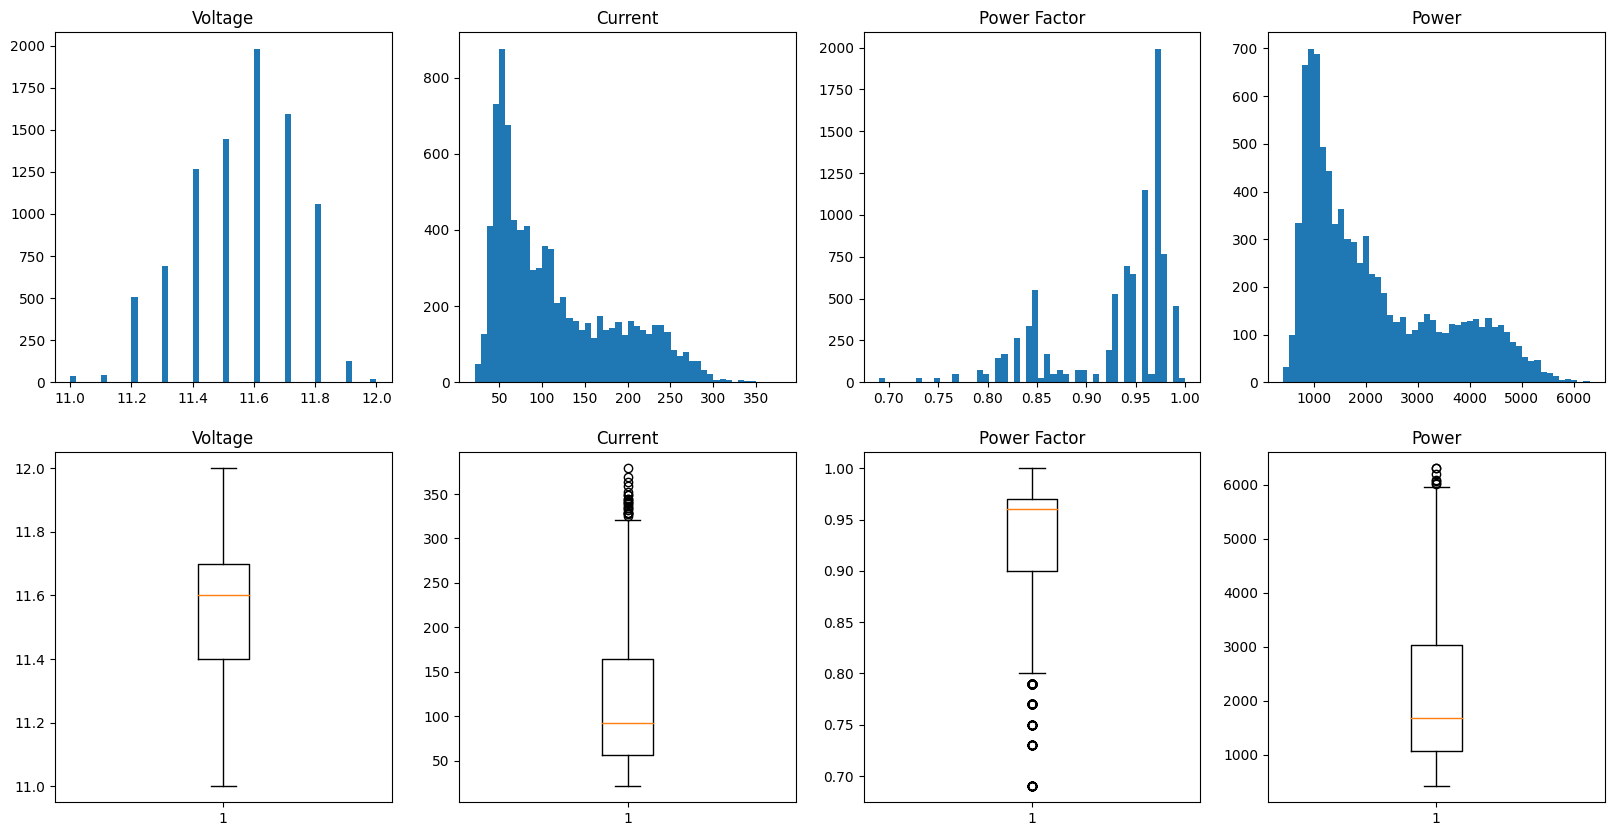

In [14]:
# Visualize the distribution of each variable using histograms and box plots
fig, axs = plt.subplots(2, 4, figsize=(20,10))
axs[0,0].hist(df['VOLTAGE'], bins=50)
axs[0,0].set_title('Voltage')
axs[0,1].hist(df['CURRENT'], bins=50)
axs[0,1].set_title('Current')
axs[0,2].hist(df['PF'], bins=50)
axs[0,2].set_title('Power Factor')
axs[0,3].hist(df['POWER (KW)'], bins=50)
axs[0,3].set_title('Power')
axs[1,0].boxplot(df['VOLTAGE'])
axs[1,0].set_title('Voltage')
axs[1,1].boxplot(df['CURRENT'])
axs[1,1].set_title('Current')
axs[1,2].boxplot(df['PF'])
axs[1,2].set_title('Power Factor')
axs[1,3].boxplot(df['POWER (KW)'])
axs[1,3].set_title('Power')
plt.show()

In [15]:
df = df.drop(["DATE", "TIME"], axis=1)

# Outlier Replacement Using Winsorization

In [16]:
# Define the columns to Winsorize
cols = ["VOLTAGE", "CURRENT", "PF", "POWER (KW)", "SEASON", "Temp (F)", "Humidity (%)"]

# Calculate the 5th and 95th percentiles
low_limit = df[cols].quantile(0.05)
high_limit = df[cols].quantile(0.95)

# Winsorize the columns
winsorized = np.where(df[cols] >= high_limit, high_limit,
                      np.where(df[cols] <= low_limit, low_limit, df[cols]))

# Create a new DataFrame with the same column names and index as the original DataFrame
df_winsorized = pd.DataFrame(winsorized, columns=cols, index=df.index)

# Replace the original columns with the Winsorized columns
df[cols] = df_winsorized

# View the final DataFrame
print(df.head())


                     VOLTAGE  CURRENT    PF  POWER (KW)  "WEEKEND/WEEKDAY"  \
datetime                                                                     
2021-01-01 01:00:00     11.6    102.0  0.96      1967.0                  0   
2021-01-01 02:00:00     11.6    102.0  0.96      1967.0                  0   
2021-01-01 03:00:00     11.6    102.0  0.96      1967.0                  0   
2021-01-01 04:00:00     11.3    130.0  0.96      2443.0                  0   
2021-01-01 05:00:00     11.2    148.0  0.96      2756.0                  0   

                     SEASON  Temp (F)  Humidity (%)  Substation Shutdown  F1  \
datetime                                                                       
2021-01-01 01:00:00     1.0      66.0          90.0                  NaN NaN   
2021-01-01 02:00:00     1.0      66.0          90.0                  NaN NaN   
2021-01-01 03:00:00     1.0      66.0          90.0                  NaN NaN   
2021-01-01 04:00:00     1.0      78.0          49.0  

In [17]:
df.describe()

,VOLTAGE,CURRENT,PF,POWER (KW),"""WEEKEND/WEEKDAY""",SEASON,Temp (F),Humidity (%),Substation Shutdown,F1,F2,F3,F4,0
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.00000,8760.000000,8760.000000,66.0,25.0,71.0,97.0,46.0,2.000000
mean,11.549726,113.794635,0.931145,2115.669977,0.142466,0.99726,81.201598,67.969292,1.0,1.0,1.0,1.0,1.0,1.500000
std,0.173366,66.837620,0.054040,1254.366496,0.349547,0.81933,8.111901,20.034451,0.0,0.0,0.0,0.0,0.0,0.707107
min,11.200000,40.000000,0.820000,757.000000,0.000000,0.00000,66.000000,30.000000,1.0,1.0,1.0,1.0,1.0,1.000000
25%,11.400000,56.750000,0.900000,1063.000000,0.000000,0.00000,76.000000,52.000000,1.0,1.0,1.0,1.0,1.0,1.250000
50%,11.600000,92.000000,0.960000,1683.500000,0.000000,1.00000,81.000000,72.000000,1.0,1.0,1.0,1.0,1.0,1.500000
75%,11.700000,164.000000,0.970000,3026.000000,0.000000,2.00000,86.000000,87.000000,1.0,1.0,1.0,1.0,1.0,1.750000
max,11.800000,251.000000,0.990000,4712.000000,1.000000,2.00000,97.000000,93.000000,1.0,1.0,1.0,1.0,1.0,2.000000


In [18]:
df

,VOLTAGE,CURRENT,PF,POWER (KW),"""WEEKEND/WEEKDAY""",SEASON,Temp (F),Humidity (%),Substation Shutdown,F1,F2,F3,F4,Jul-Oct-,Rainy,0,datetime
datetime,,,,,,,,,,,,,,,,,
2021-01-01 01:00:00,11.6,102.0,0.96,1967.0,0,1.0,66.0,90.0,NaN,NaN,NaN,NaN,NaN,Nov-Feb,Winter,1.0,2021-01-01 01:00:00
2021-01-01 02:00:00,11.6,102.0,0.96,1967.0,0,1.0,66.0,90.0,NaN,NaN,NaN,NaN,NaN,Mar-Jun,Summer,2.0,2021-01-01 02:00:00
2021-01-01 03:00:00,11.6,102.0,0.96,1967.0,0,1.0,66.0,90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-01 03:00:00
2021-01-01 04:00:00,11.3,130.0,0.96,2443.0,0,1.0,78.0,49.0,NaN,NaN,NaN,NaN,NaN,Weekend,1,NaN,2021-01-01 04:00:00
2021-01-01 05:00:00,11.2,148.0,0.96,2756.0,0,1.0,78.0,49.0,NaN,NaN,NaN,NaN,NaN,Weekday,0,NaN,2021-01-01 05:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 20:00:00,11.6,64.0,0.95,1222.0,0,1.0,67.0,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 20:00:00
2021-12-31 21:00:00,11.5,62.0,0.95,1173.0,0,1.0,67.0,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 21:00:00
2021-12-31 22:00:00,11.5,57.0,0.95,1079.0,0,1.0,66.0,93.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 22:00:00


In [19]:
df.tail()

,VOLTAGE,CURRENT,PF,POWER (KW),"""WEEKEND/WEEKDAY""",SEASON,Temp (F),Humidity (%),Substation Shutdown,F1,F2,F3,F4,Jul-Oct-,Rainy,0,datetime
datetime,,,,,,,,,,,,,,,,,
2021-12-31 20:00:00,11.6,64.0,0.95,1222.0,0,1.0,67.0,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 20:00:00
2021-12-31 21:00:00,11.5,62.0,0.95,1173.0,0,1.0,67.0,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 21:00:00
2021-12-31 22:00:00,11.5,57.0,0.95,1079.0,0,1.0,66.0,93.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 22:00:00
2021-12-31 23:00:00,11.5,48.0,0.95,908.0,0,1.0,66.0,93.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 23:00:00
2021-12-31 00:00:00,11.6,44.0,0.95,840.0,0,1.0,66.0,93.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 00:00:00


# Stationarity Test

In [20]:
from statsmodels.tsa.stattools import adfuller


# Perform ADF test for each variable
for column in ["VOLTAGE", "CURRENT", "PF", "POWER (KW)", "Temp (F)", "Humidity (%)"]:
    adf_test = adfuller(df[column])
    adf_statistic = adf_test[0]
    adf_p_value = adf_test[1]
    adf_critical_values = adf_test[4]

    # Print test results
    print(f'Variable: {column}')
    print(f'Statistic: {adf_statistic}')
    print(f'p-value: {adf_p_value}')
    print(f'Critical Values: {adf_critical_values}')

    # Interpret test results
    if adf_p_value < 0.05:
        print('The null hypothesis of stationarity is rejected. The data is stationary.')
    else:
        print('The null hypothesis of stationarity is not rejected. The data is not stationary.')
    print('\n')


Variable: VOLTAGE
Statistic: -9.616969555778226
p-value: 1.7498644307187982e-16
Critical Values: {'1%': -3.4310992810810093, '5%': -2.8618711323619297, '10%': -2.566946256788549}
The null hypothesis of stationarity is rejected. The data is stationary.


Variable: CURRENT
Statistic: -4.478981900369547
p-value: 0.00021456957814997607
Critical Values: {'1%': -3.431099882538333, '5%': -2.8618713981324873, '10%': -2.56694639826003}
The null hypothesis of stationarity is rejected. The data is stationary.


Variable: PF
Statistic: -3.3807993879680023
p-value: 0.011631095652011628
Critical Values: {'1%': -3.431098852059003, '5%': -2.8618709427866547, '10%': -2.5669461558763422}
The null hypothesis of stationarity is rejected. The data is stationary.


Variable: POWER (KW)
Statistic: -4.3690125899924395
p-value: 0.0003366436250050715
Critical Values: {'1%': -3.431099882538333, '5%': -2.8618713981324873, '10%': -2.56694639826003}
The null hypothesis of stationarity is rejected. The data is stati

In [21]:
import statsmodels.api as sm



# Perform Phillips-Perron test for each variable
for column in ["VOLTAGE", "CURRENT", "PF", "POWER (KW)", "Temp (F)", "Humidity (%)"]:
    pp_test = sm.tsa.stattools.adfuller(df[column], regression='nc', autolag='AIC')
    pp_statistic = pp_test[0]
    pp_p_value = pp_test[1]
    pp_critical_values = pp_test[4]

    # Print test results
    print(f'Variable: {column}')
    print(f'Statistic: {pp_statistic}')
    print(f'p-value: {pp_p_value}')
    print(f'Critical Values: {pp_critical_values}')

    # Interpret test results
    if pp_p_value < 0.05:
        print('The null hypothesis of stationarity is rejected. The data is stationary.')
    else:
        print('The null hypothesis of stationarity is not rejected. The data is not stationary.')
    print('\n')


Variable: VOLTAGE
Statistic: -0.11181144291027179
p-value: 0.6458615797443361
Critical Values: {'1%': -2.5659962116818424, '5%': -1.9410308186446974, '10%': -1.6167896047915096}
The null hypothesis of stationarity is not rejected. The data is not stationary.


Variable: CURRENT
Statistic: -1.4857436345369426
p-value: 0.128623780090308
Critical Values: {'1%': -2.565996358568992, '5%': -1.9410308363351416, '10%': -1.6167895873894476}
The null hypothesis of stationarity is not rejected. The data is not stationary.


Variable: PF
Statistic: -0.20504464155532995
p-value: 0.6120395282210647
Critical Values: {'1%': -2.565996006322393, '5%': -1.941030793912148, '10%': -1.6167896291209662}
The null hypothesis of stationarity is not rejected. The data is not stationary.


Variable: POWER (KW)
Statistic: -1.4918177631290217
p-value: 0.1271740824014806
Critical Values: {'1%': -2.565996358568992, '5%': -1.9410308363351416, '10%': -1.6167895873894476}
The null hypothesis of stationarity is not rejec

In [24]:
from statsmodels.tsa.stattools import kpss

import warnings

warnings.filterwarnings("ignore")


# Extract the variables of interest from the DataFrame
# Assuming the variables are stored in columns 'VOLTAGE', 'CURRENT', 'PF', 'POWER (KW)', 'Temp (F)', and 'Humidity (%)'
var1 = df['VOLTAGE']
var2 = df['CURRENT']
var3 = df['PF']
var4 = df['POWER (KW)']
var5 = df['Temp (F)']
var6 = df['Humidity (%)']

# Perform KPSS test on each variable
def conduct_kpss_test(data, variable_name):
    statistic, p_value, lags, critical_values = kpss(data)
    print(f'Variable: {variable_name}')
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'  {key}: {value}')
    if p_value < 0.05:
        print('The null hypothesis of stationarity is rejected and data is not stationary.')
    else:
        print('The null hypothesis of stationarity is not rejected and data is stationary.')

# Call the function for each variable
conduct_kpss_test(var1, 'VOLTAGE')
conduct_kpss_test(var2, 'CURRENT')
conduct_kpss_test(var3, 'PF')
conduct_kpss_test(var4, 'POWER (KW)')
conduct_kpss_test(var5, 'Temp (F)')
conduct_kpss_test(var6, 'Humidity (%)')


Variable: VOLTAGE
KPSS Statistic: 1.421340324688324
p-value: 0.01
Critical Values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739
The null hypothesis of stationarity is rejected and data is not stationary.
Variable: CURRENT
KPSS Statistic: 3.2607074929830753
p-value: 0.01
Critical Values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739
The null hypothesis of stationarity is rejected and data is not stationary.
Variable: PF
KPSS Statistic: 4.8446918765848155
p-value: 0.01
Critical Values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739
The null hypothesis of stationarity is rejected and data is not stationary.
Variable: POWER (KW)
KPSS Statistic: 4.251036773004606
p-value: 0.01
Critical Values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739
The null hypothesis of stationarity is rejected and data is not stationary.
Variable: Temp (F)
KPSS Statistic: 3.519217096497965
p-value: 0.01
Critical Values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739
The null hypothesis of st

# Making Data Staionary using Differencing

In [25]:
# Create a copy of the original dataframe
df_diff = df.copy()

# Apply differencing to the copy
df_diff['VOLTAGE'] = df['VOLTAGE'] - df['VOLTAGE'].shift(1)
df_diff['CURRENT'] = df['CURRENT'] - df['CURRENT'].shift(1)
df_diff['PF'] = df['PF'] - df['PF'].shift(1)
df_diff['POWER (KW)'] = df['POWER (KW)'] - df['POWER (KW)'].shift(1)
df_diff['Temp (F)'] = df['Temp (F)'] - df['Temp (F)'].shift(1)
df_diff['Humidity (%)'] = df['Humidity (%)'] - df['Humidity (%)'].shift(1)

# Drop the first row since it contains NaN values
df_diff = df_diff.drop(index='2021-01-01 01:00:00')


In [26]:
df_diff

,VOLTAGE,CURRENT,PF,POWER (KW),"""WEEKEND/WEEKDAY""",SEASON,Temp (F),Humidity (%),Substation Shutdown,F1,F2,F3,F4,Jul-Oct-,Rainy,0,datetime
datetime,,,,,,,,,,,,,,,,,
2021-01-01 02:00:00,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,Mar-Jun,Summer,2.0,2021-01-01 02:00:00
2021-01-01 03:00:00,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-01 03:00:00
2021-01-01 04:00:00,-0.3,28.0,0.0,476.0,0,1.0,12.0,-41.0,NaN,NaN,NaN,NaN,NaN,Weekend,1,NaN,2021-01-01 04:00:00
2021-01-01 05:00:00,-0.1,18.0,0.0,313.0,0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,Weekday,0,NaN,2021-01-01 05:00:00
2021-01-01 06:00:00,0.0,24.0,0.0,447.0,0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,Missing Values,66,NaN,2021-01-01 06:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 20:00:00,0.0,-1.0,0.0,-19.0,0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 20:00:00
2021-12-31 21:00:00,-0.1,-2.0,0.0,-49.0,0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 21:00:00
2021-12-31 22:00:00,0.0,-5.0,0.0,-94.0,0,1.0,-1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 22:00:00


In [27]:
import statsmodels.api as sm



# Perform Phillips-Perron test for each variable
for column in ["VOLTAGE", "CURRENT", "PF", "POWER (KW)", "Temp (F)", "Humidity (%)"]:
    pp_test = sm.tsa.stattools.adfuller(df_diff[column], regression='nc', autolag='AIC')
    pp_statistic = pp_test[0]
    pp_p_value = pp_test[1]
    pp_critical_values = pp_test[4]

    # Print test results
    print(f'Variable: {column}')
    print(f'Statistic: {pp_statistic}')
    print(f'p-value: {pp_p_value}')
    print(f'Critical Values: {pp_critical_values}')

    # Interpret test results
    if pp_p_value < 0.05:
        print('The null hypothesis of stationarity is rejected. The data is stationary.')
    else:
        print('The null hypothesis of stationarity is not rejected. The data is not stationary.')
    print('\n')

Variable: VOLTAGE
Statistic: -26.33430831728936
p-value: 0.0
Critical Values: {'1%': -2.5659962116818424, '5%': -1.9410308186446974, '10%': -1.6167896047915096}
The null hypothesis of stationarity is rejected. The data is stationary.


Variable: CURRENT
Statistic: -18.528546433973936
p-value: 3.824431489319445e-29
Critical Values: {'1%': -2.565996358568992, '5%': -1.9410308363351416, '10%': -1.6167895873894476}
The null hypothesis of stationarity is rejected. The data is stationary.


Variable: PF
Statistic: -28.424594730554755
p-value: 0.0
Critical Values: {'1%': -2.565996006322393, '5%': -1.941030793912148, '10%': -1.6167896291209662}
The null hypothesis of stationarity is rejected. The data is stationary.


Variable: POWER (KW)
Statistic: -18.55526643181168
p-value: 3.7870517481237177e-29
Critical Values: {'1%': -2.565996358568992, '5%': -1.9410308363351416, '10%': -1.6167895873894476}
The null hypothesis of stationarity is rejected. The data is stationary.


Variable: Temp (F)
Stat

In [28]:
df_diff.describe()

,VOLTAGE,CURRENT,PF,POWER (KW),"""WEEKEND/WEEKDAY""",SEASON,Temp (F),Humidity (%),Substation Shutdown,F1,F2,F3,F4,0
count,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.00000,8759.000000,66.0,25.0,71.0,97.0,46.0,1.0
mean,0.000000,-0.006622,-0.000001,-0.128668,0.142482,0.997260,0.00000,0.000343,1.0,1.0,1.0,1.0,1.0,2.0
std,0.131463,28.164054,0.005634,524.091056,0.349564,0.819377,3.06886,8.996948,0.0,0.0,0.0,0.0,0.0,NaN
min,-0.600000,-207.000000,-0.170000,-3865.000000,0.000000,0.000000,-19.00000,-61.000000,1.0,1.0,1.0,1.0,1.0,2.0
25%,0.000000,-4.000000,0.000000,-72.000000,0.000000,0.000000,0.00000,0.000000,1.0,1.0,1.0,1.0,1.0,2.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,1.0,1.0,1.0,1.0,1.0,2.0
75%,0.000000,5.000000,0.000000,85.000000,0.000000,2.000000,0.00000,0.000000,1.0,1.0,1.0,1.0,1.0,2.0
max,0.600000,210.000000,0.130000,3608.000000,1.000000,2.000000,18.00000,56.000000,1.0,1.0,1.0,1.0,1.0,2.0


# Finding Correlation between Variables

In [29]:
# Select the two variables for which you want to calculate the correlation
var1 = df['POWER (KW)']
var2 = df['Temp (F)']

# Calculate the correlation between the two variables using the corr() function
corr = var1.corr(var2)

print('Correlation between POWER(KW) and Temp (F):', corr)


Correlation between POWER(KW) and Temp (F): 0.16838079865106553


In [30]:
# Select the two variables for which you want to calculate the correlation
var1 = df['POWER (KW)']
var2 = df['Humidity (%)']

# Calculate the correlation between the two variables using the corr() function
corr = var1.corr(var2)

print('Correlation between POWER(KW) and Humidity (%):', corr)


Correlation between POWER(KW) and Humidity (%): -0.4215896513149493


In [31]:
# Separate the data for variable1 where it is 0 or 1
df_0 = df[df['"WEEKEND/WEEKDAY"'] == 0]
df_1 = df[df['"WEEKEND/WEEKDAY"'] == 1]

# Calculate the average of variable2 where variable1 is 0 or 1
avg_0 = df_0['POWER (KW)'].mean()
avg_1 = df_1['POWER (KW)'].mean()

print('Average of POWER (KW) where "WEEKEND/WEEKDAY" is 0:', avg_0)
print('Average of POWER (KW) where "WEEKEND/WEEKDAY" is 1:', avg_1)


Average of POWER (KW) where "WEEKEND/WEEKDAY" is 0: 2108.574148029819
Average of POWER (KW) where "WEEKEND/WEEKDAY" is 1: 2158.38141025641


In [32]:
# Separate the data for variable1 where it is 0 or 1.0 or 2.0
df_0 = df[df['SEASON'] == 0]
df_1 = df[df['SEASON'] == 1.0]
df_2 = df[df['SEASON'] == 2.0]

# Calculate the average of variable2 where variable1 is 0 or 1.0 or 2.0
avg_0 = df_0['POWER (KW)'].mean()
avg_1 = df_1['POWER (KW)'].mean()
avg_2 = df_2['POWER (KW)'].mean()

print('Average of POWER (KW) where "SEASON" is Rainy:', avg_0)
print('Average of POWER (KW) where "SEASON" is Winter:', avg_1)
print('Average of POWER (KW) where "SEASON" is Summer:', avg_2)

Average of POWER (KW) where "SEASON" is Rainy: 1991.956300813008
Average of POWER (KW) where "SEASON" is Winter: 2439.1225694444443
Average of POWER (KW) where "SEASON" is Summer: 1922.2476092896175


In [33]:
# Separate the data for variable1 where it is 0 or 1.0 or 2.0
df_0 = df[(df['SEASON'] == 0) & (df['"WEEKEND/WEEKDAY"'] == 0)]
df_1 = df[(df['SEASON'] == 0) & (df['"WEEKEND/WEEKDAY"'] == 1)]
df_2 = df[(df['SEASON'] == 1.0) & (df['"WEEKEND/WEEKDAY"'] == 0)]
df_3 = df[(df['SEASON'] == 1.0) & (df['"WEEKEND/WEEKDAY"'] == 1)]
df_4 = df[(df['SEASON'] == 2.0) & (df['"WEEKEND/WEEKDAY"'] == 0)]
df_5 = df[(df['SEASON'] == 2.0) & (df['"WEEKEND/WEEKDAY"'] == 1)]

# Calculate the average of variable2 where variable1 is 0 or 1.0 or 2.0
avg_0 = df_0['POWER (KW)'].mean()
avg_1 = df_1['POWER (KW)'].mean()
avg_2 = df_2['POWER (KW)'].mean()
avg_3 = df_3['POWER (KW)'].mean()
avg_4 = df_4['POWER (KW)'].mean()
avg_5 = df_5['POWER (KW)'].mean()

print('Average of POWER (KW) where "SEASON" is Rainy and Its a Weekday :', avg_0)
print('Average of POWER (KW) where "SEASON" is Rainy and Its a Weekend:', avg_1)
print('Average of POWER (KW) where "SEASON" is Winter and Its a Weekday:', avg_2)
print('Average of POWER (KW) where "SEASON" is Winter and Its a Weekend:', avg_3)
print('Average of POWER (KW) where "SEASON" is Summer and Its a Weekday:', avg_4)
print('Average of POWER (KW) where "SEASON" is Summer and Its a Weekend:', avg_5)

Average of POWER (KW) where "SEASON" is Rainy and Its a Weekday : 1975.5015873015873
Average of POWER (KW) where "SEASON" is Rainy and Its a Weekend: 2087.9421296296296
Average of POWER (KW) where "SEASON" is Winter and Its a Weekday: 2431.0044498381876
Average of POWER (KW) where "SEASON" is Winter and Its a Weekend: 2488.3088235294117
Average of POWER (KW) where "SEASON" is Summer and Its a Weekday: 1925.3579365079365
Average of POWER (KW) where "SEASON" is Summer and Its a Weekend: 1903.0367647058824


In [34]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


# Feature Extraction

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# define the list of feature subsets to test
feature_subsets = [['VOLTAGE'], ['VOLTAGE', 'CURRENT'], ['VOLTAGE', 'CURRENT', 'PF'], ['VOLTAGE', 'CURRENT', 'PF', 'Temp (F)'],
                  ['VOLTAGE', 'CURRENT', 'PF', 'Temp (F)', 'Humidity (%)']]

# initialize the list to store the MSE values for each feature subset
mse_values = []

# loop through the feature subsets and evaluate the performance of the model with each subset
for features in feature_subsets:
    # create the feature matrix X and the target variable y
    X = df[features]
    y = df['POWER (KW)']

    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # initialize the random forest regressor
    rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)

    # fit the regressor to the training data
    rf_reg.fit(X_train, y_train)

    # predict the target variable for the testing data
    y_pred = rf_reg.predict(X_test)

    # calculate the MSE value for the current feature subset
    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)

# print the MSE values for each feature subset
print("MSE values:", mse_values)

# find the index of the feature subset with the lowest MSE value
min_mse_index = mse_values.index(min(mse_values))

# get the corresponding feature subset
selected_features = feature_subsets[min_mse_index]

print("Selected features:", selected_features)


MSE values: [1394554.7189075022, 20691.914148374468, 813.9138445617077, 827.2380297819618, 777.7976961432123]
Selected features: ['VOLTAGE', 'CURRENT', 'PF', 'Temp (F)', 'Humidity (%)']


# Model Selection

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Set up data
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

# Set up exogenous variables
exog_train = train_data[['VOLTAGE', 'CURRENT', 'PF', 'Temp (F)','Humidity (%)']]
exog_test = test_data[['VOLTAGE', 'CURRENT', 'PF', 'Temp (F)','Humidity (%)']]

# Set up endogenous variable
endog_train = train_data['POWER (KW)']
endog_test = test_data['POWER (KW)']

# Set up linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(exog_train, endog_train)

# Predict on the test data
forecast = model.predict(exog_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(endog_test, forecast))
print(f"RMSE: {rmse}")

# Calculate evaluation metrics
mse = mean_squared_error(endog_test, forecast)
mae = mean_absolute_error(endog_test, forecast)
r2 = r2_score(endog_test, forecast)
mape = round(np.mean(abs((endog_test - forecast) / endog_test)) * 100, 4)
smape = round(np.mean(2 * abs(forecast - endog_test) / (abs(forecast) + abs(endog_test))) * 100, 4)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Symmetric Mean Absolute Percentage Error (SMAPE):", smape)


RMSE: 25.50411830997101
Mean Squared Error (MSE): 650.4600507689985
Mean Absolute Error (MAE): 17.192242245778488
R-squared (R2) Score: 0.9993319564593112
Mean Absolute Percentage Error (MAPE): 1.1698
Symmetric Mean Absolute Percentage Error (SMAPE): 1.1826



# Model Testing

In [37]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LinearRegression

# Set up data
train_size = int(len(df) * 0.8)
train_data = df[:train_size]
test_data = df[train_size:]

# Set up features and target variables
features = ['VOLTAGE', 'CURRENT', 'PF', 'Temp (F)', 'Humidity (%)']
target = ['POWER (KW)']

# Set up exogenous variables
exog_train = train_data[features]
exog_test = test_data[features]

# Set up endogenous variable
endog_train = train_data[target]
endog_test = test_data[target]

# Set up linear regression model
model = LinearRegression()

# Train linear regression model
model.fit(exog_train, endog_train)

# Forecast on test data
forecast = model.predict(exog_test)


# Print forecasted values
print("Forecasted values:")
print(forecast)

Forecasted values:
[[1258.65143334]
 [1258.65143334]
 [1258.65143334]
 ...
 [1076.06703824]
 [ 907.00633125]
 [ 853.72382083]]


In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define MAPE and SMAPE functions
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100

# Calculate evaluation metrics
mse = mean_squared_error(endog_test, forecast)
mae = mean_absolute_error(endog_test, forecast)
r2 = r2_score(endog_test, forecast)
mape = mean_absolute_percentage_error(endog_test, forecast)
smape = symmetric_mean_absolute_percentage_error(endog_test, forecast)

# Print evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Symmetric Mean Absolute Percentage Error (SMAPE):", smape)


Mean Squared Error (MSE): 650.4600507689985
Mean Absolute Error (MAE): 17.192242245778488
R-squared (R2) Score: 0.9993319564593112
Mean Absolute Percentage Error (MAPE): POWER (KW)    1.169834
dtype: float64
Symmetric Mean Absolute Percentage Error (SMAPE): POWER (KW)    1.182585
dtype: float64


# Validation

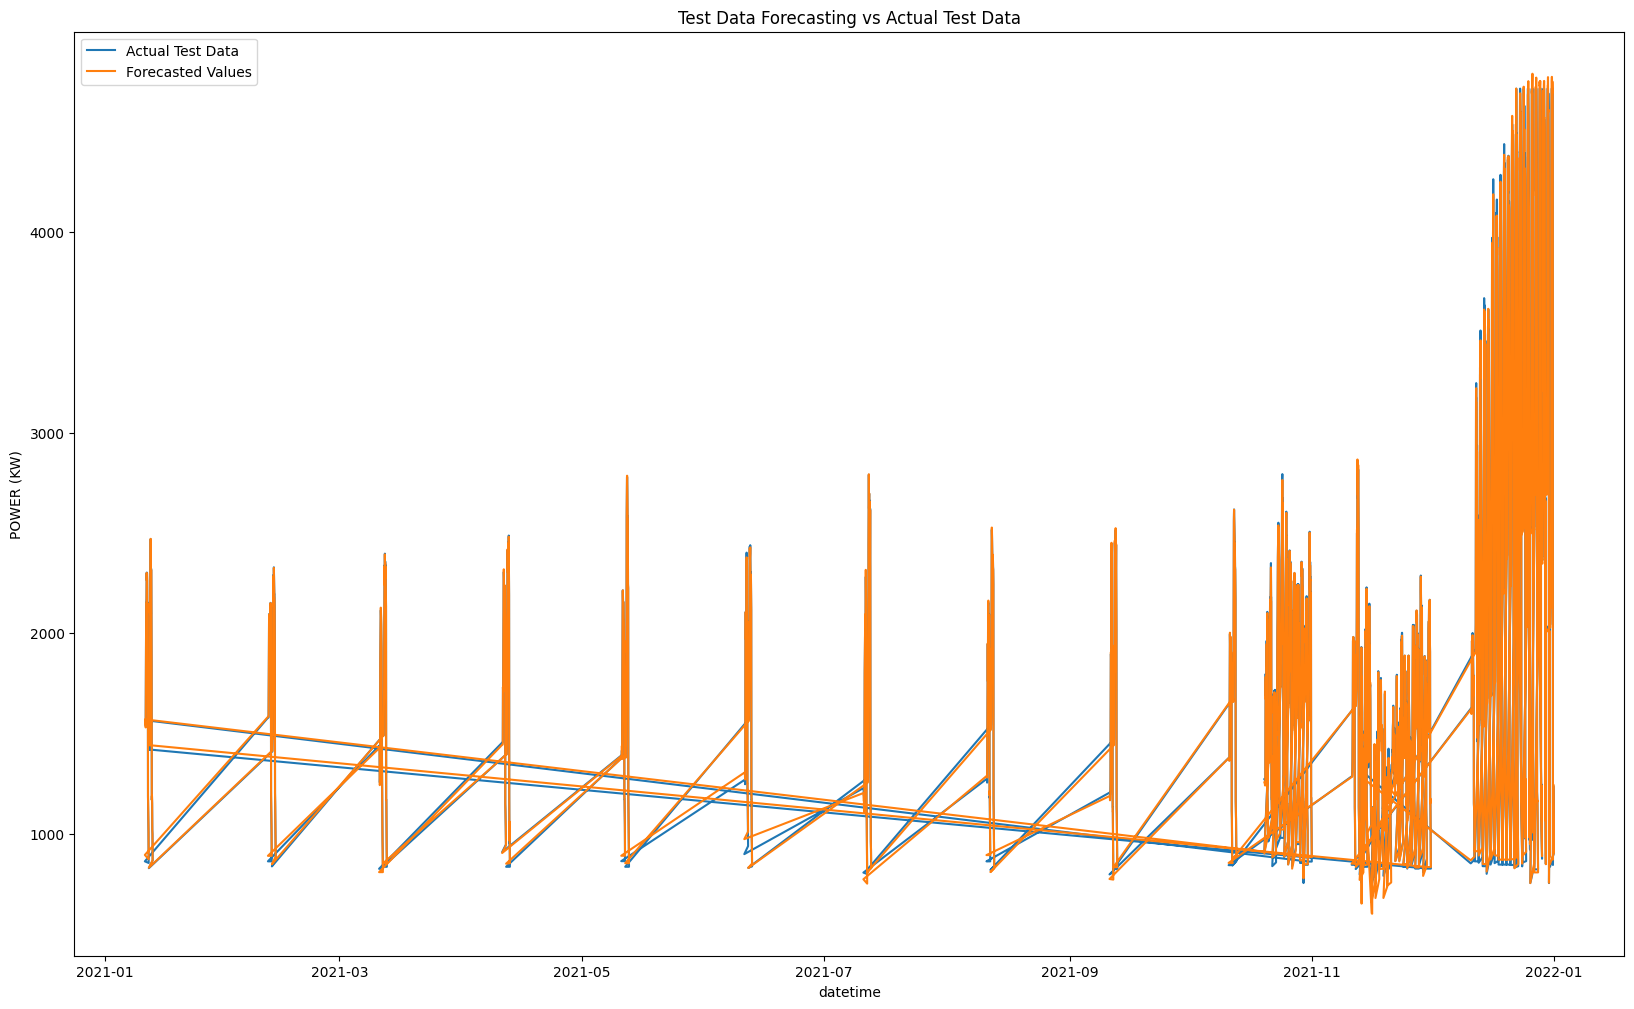

In [39]:
import matplotlib.pyplot as plt

# Assuming test data is in a DataFrame called "test_data" with the actual values in a column named "POWER (KW)"

# Convert forecast NumPy array to Pandas Series
forecast_series = pd.Series(forecast.flatten(), index=test_data.index)

# Extract the forecasted values from the Series
forecasted_values = forecast_series.values

# Extract the index from the test data for x-axis
x_axis = test_data.index

# Plot the actual test data and forecasted values
plt.figure(figsize=(20, 12))
plt.plot(x_axis, endog_test, label='Actual Test Data')
plt.plot(x_axis, forecasted_values, label='Forecasted Values')
plt.xlabel('datetime')
plt.ylabel('POWER (KW)')
plt.title('Test Data Forecasting vs Actual Test Data')
plt.legend()
plt.show()


# Forecasting For Next 1 Year

In [40]:
from sklearn.linear_model import LinearRegression

# Set up data
train_data = df

# Set up exogenous variables
exog_train = train_data[['VOLTAGE', 'CURRENT', 'PF', 'Temp (F)', 'Humidity (%)']]

# Set up endogenous variable
endog_train = train_data['POWER (KW)']

# Set up linear regression model
model = LinearRegression()
model.fit(exog_train, endog_train)

# forecast next 1 year
exog_forecast = exog_train[-8760:]
forecast = model.predict(exog_forecast)

# print forecast
print("Forecasted power consumption (KW) for the next 1 year:")
print(forecast)


Forecasted power consumption (KW) for the next 1 year:
[1965.66381435 1965.66381435 1965.66381435 ... 1077.91126219  908.85800333
  855.19592924]


In [41]:
# create date range starting from 2022-01-01 01:00:00
date_rng = pd.date_range(start='2022-01-01 01:00:00', end='2023-01-01 00:00:00', freq='H')

# create dataframe of forecast results
forecast_df = pd.DataFrame({'datetime': date_rng, 'POWER (KW)': forecast})

# save forecast results to csv file
forecast_df.to_csv('C:/Advance Substation Forecasting/power_consumption_forecast.csv', index=False)

print("Forecast saved to power_consumption_forecast.csv")

Forecast saved to power_consumption_forecast.csv


In [42]:
df = df.rename(columns={'datetime': 'datetime_new'})
df

,VOLTAGE,CURRENT,PF,POWER (KW),"""WEEKEND/WEEKDAY""",SEASON,Temp (F),Humidity (%),Substation Shutdown,F1,F2,F3,F4,Jul-Oct-,Rainy,0,datetime_new
datetime,,,,,,,,,,,,,,,,,
2021-01-01 01:00:00,11.6,102.0,0.96,1967.0,0,1.0,66.0,90.0,NaN,NaN,NaN,NaN,NaN,Nov-Feb,Winter,1.0,2021-01-01 01:00:00
2021-01-01 02:00:00,11.6,102.0,0.96,1967.0,0,1.0,66.0,90.0,NaN,NaN,NaN,NaN,NaN,Mar-Jun,Summer,2.0,2021-01-01 02:00:00
2021-01-01 03:00:00,11.6,102.0,0.96,1967.0,0,1.0,66.0,90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-01 03:00:00
2021-01-01 04:00:00,11.3,130.0,0.96,2443.0,0,1.0,78.0,49.0,NaN,NaN,NaN,NaN,NaN,Weekend,1,NaN,2021-01-01 04:00:00
2021-01-01 05:00:00,11.2,148.0,0.96,2756.0,0,1.0,78.0,49.0,NaN,NaN,NaN,NaN,NaN,Weekday,0,NaN,2021-01-01 05:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 20:00:00,11.6,64.0,0.95,1222.0,0,1.0,67.0,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 20:00:00
2021-12-31 21:00:00,11.5,62.0,0.95,1173.0,0,1.0,67.0,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 21:00:00
2021-12-31 22:00:00,11.5,57.0,0.95,1079.0,0,1.0,66.0,93.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 22:00:00


In [43]:
df_forecasted = pd.read_csv(r'C:/Advance Substation Forecasting/power_consumption_forecast.csv')
df_forecasted['datetime'] = pd.to_datetime(df_forecasted['datetime'], format='%Y-%m-%d %H:%M:%S')


# Hourly Data Plot

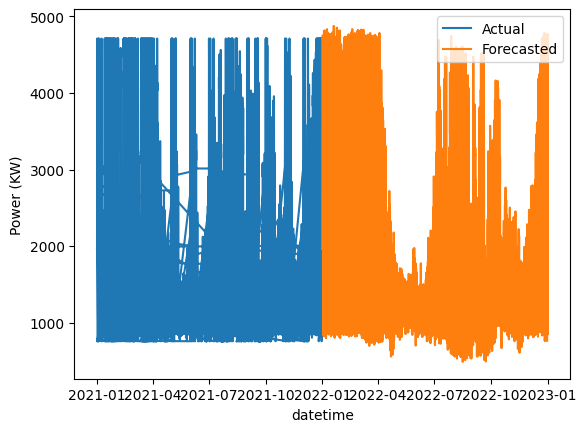

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot POWER (KW) column from both files
plt.plot(df['datetime_new'], df['POWER (KW)'], label='Actual')
plt.plot(df_forecasted['datetime'], df_forecasted['POWER (KW)'], label='Forecasted')

# Set axis labels and legend
plt.xlabel('datetime')
plt.ylabel('Power (KW)')
plt.legend()

# Show the plot
plt.show()


# Feature Extraction, Model Testing and Forecasting for Daily Interval

In [45]:
df_daily = df.resample('D', on='datetime_new').sum()
feature_subsets = [['VOLTAGE'], ['VOLTAGE', 'CURRENT'], ['VOLTAGE', 'CURRENT', 'PF'], ['VOLTAGE', 'CURRENT', 'PF', 'Temp (F)'],
                  ['VOLTAGE', 'CURRENT', 'PF', 'Temp (F)', 'Humidity (%)']]

# initialize the list to store the MSE values for each feature subset
mse_values = []

# loop through the feature subsets and evaluate the performance of the model with each subset
for features in feature_subsets:
    # create the feature matrix X and the target variable y
    X = df_daily[features]
    y = df_daily['POWER (KW)']

    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # initialize the random forest regressor
    rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)

    # fit the regressor to the training data
    rf_reg.fit(X_train, y_train)

    # predict the target variable for the testing data
    y_pred = rf_reg.predict(X_test)

    # calculate the MSE value for the current feature subset
    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)

# print the MSE values for each feature subset
print("MSE values:", mse_values)

# find the index of the feature subset with the lowest MSE value
min_mse_index = mse_values.index(min(mse_values))

# get the corresponding feature subset
selected_features = feature_subsets[min_mse_index]

print("Selected features:", selected_features)


MSE values: [543853148.1767771, 6359704.309561645, 447484.3564917807, 875677.8480383562, 1057649.4439232883]
Selected features: ['VOLTAGE', 'CURRENT', 'PF']


In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Set up data
train_data, test_data = train_test_split(df_daily, test_size=0.2, shuffle=False)

# Set up exogenous variables
exog_train = train_data[['VOLTAGE', 'CURRENT', 'PF']]
exog_test = test_data[['VOLTAGE', 'CURRENT', 'PF']]

# Set up endogenous variable
endog_train = train_data['POWER (KW)']
endog_test = test_data['POWER (KW)']

# Set up linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(exog_train, endog_train)

# Predict on the test data
forecast = model.predict(exog_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(endog_test, forecast))
print(f"RMSE: {rmse}")

# Calculate evaluation metrics
mse = mean_squared_error(endog_test, forecast)
mae = mean_absolute_error(endog_test, forecast)
r2 = r2_score(endog_test, forecast)
mape = round(np.mean(abs((endog_test - forecast) / endog_test)) * 100, 4)
smape = round(np.mean(2 * abs(forecast - endog_test) / (abs(forecast) + abs(endog_test))) * 100, 4)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Symmetric Mean Absolute Percentage Error (SMAPE):", smape)

RMSE: 569.1373752825198
Mean Squared Error (MSE): 323917.3519434758
Mean Absolute Error (MAE): 397.5403661006788
R-squared (R2) Score: 0.9988371811306229
Mean Absolute Percentage Error (MAPE): 1.0057
Symmetric Mean Absolute Percentage Error (SMAPE): 1.0149


In [47]:
from sklearn.linear_model import LinearRegression

# Set up data
train_size = int(len(df_daily) * 0.8)
train_data = df_daily[:train_size]
test_data = df_daily[train_size:]

# Set up features and target variables
features = ['VOLTAGE', 'CURRENT', 'PF']
target = ['POWER (KW)']

# Set up exogenous variables
exog_train = train_data[features]
exog_test = test_data[features]

# Set up endogenous variable
endog_train = train_data[target]
endog_test = test_data[target]

# Set up linear regression model
model = LinearRegression()

# Train linear regression model
model.fit(exog_train, endog_train)

# Forecast on test data
forecast_daily = model.predict(exog_test)


# Print forecasted values
print("Forecasted values:")
print(forecast_daily)

Forecasted values:
[[36008.32406522]
 [40041.77505963]
 [31316.22180783]
 [43710.67135621]
 [46950.68347828]
 [42987.51107949]
 [43455.1923468 ]
 [41508.85412668]
 [40249.91740332]
 [42122.34050485]
 [40418.17261905]
 [42491.86054613]
 [73271.46164682]
 [65692.14269405]
 [77606.38678906]
 [55408.6205221 ]
 [30092.45531591]
 [22985.45111182]
 [33107.88825017]
 [70362.71233738]
 [39375.06686325]
 [64015.43082687]
 [36461.51311934]
 [47754.87839759]
 [31928.29135763]
 [36103.25885118]
 [37617.0059663 ]
 [22527.30053632]
 [28643.82903377]
 [33370.71393357]
 [26481.24684342]
 [27049.87585668]
 [33455.20860728]
 [30888.66967434]
 [35992.05529812]
 [35646.56889489]
 [31322.88196305]
 [35765.85462584]
 [38685.95694559]
 [39146.63640856]
 [34827.43922325]
 [39139.73776877]
 [70118.70285489]
 [65260.09759351]
 [77412.17764652]
 [54294.08186829]
 [31379.41518399]
 [24620.46164661]
 [36662.91356567]
 [74037.62159394]
 [44697.16275047]
 [65738.72440723]
 [38345.10402374]
 [50742.89588354]
 [51693.6

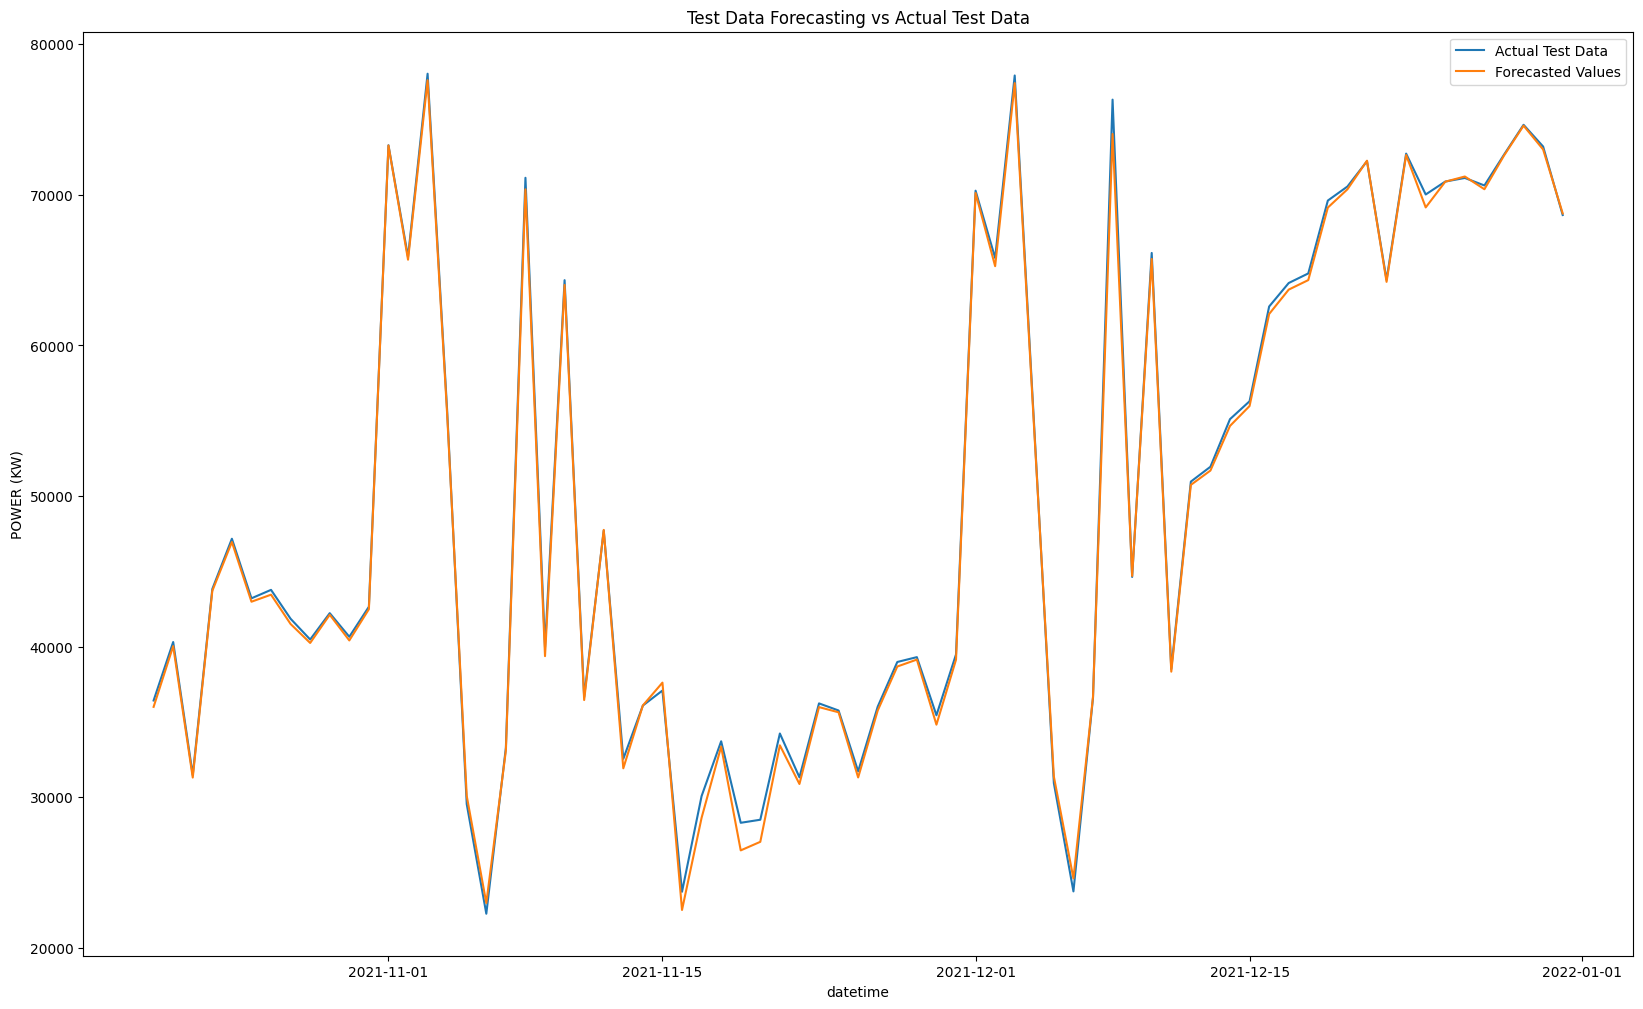

In [48]:
import matplotlib.pyplot as plt

# Assuming test data is in a DataFrame called "test_data" with the actual values in a column named "POWER (KW)"

# Convert forecast NumPy array to Pandas Series
forecast_series = pd.Series(forecast_daily.flatten(), index=test_data.index)

# Extract the forecasted values from the Series
forecasted_values = forecast_series.values

# Extract the index from the test data for x-axis
x_axis = test_data.index

# Plot the actual test data and forecasted values
plt.figure(figsize=(20, 12))
plt.plot(x_axis, endog_test, label='Actual Test Data')
plt.plot(x_axis, forecasted_values, label='Forecasted Values')
plt.xlabel('datetime')
plt.ylabel('POWER (KW)')
plt.title('Test Data Forecasting vs Actual Test Data')
plt.legend()
plt.show()


In [49]:
from sklearn.linear_model import LinearRegression

# Set up data
train_data = df_daily

# Set up exogenous variables
exog_train = train_data[['VOLTAGE', 'CURRENT', 'PF']]

# Set up endogenous variable
endog_train = train_data['POWER (KW)']

# Set up linear regression model
model = LinearRegression()
model.fit(exog_train, endog_train)

# forecast next 1 year
exog_forecast = exog_train[-365:]
forecast_daily = model.predict(exog_forecast)

# print forecast
print("Forecasted power consumption (KW) for the next 1 year:")
print(forecast_daily)


Forecasted power consumption (KW) for the next 1 year:
[68077.73346695 65099.71966823 71938.6313444  71007.82736626
 31648.2184168  29312.29071545 36866.81982141 67205.80257256
 32218.41054404 37574.6369202  41685.04731555 39925.48288354
 70351.81015352 68633.95780874 69739.73141576 72281.29015336
 70272.70473341 70066.91526603 69205.70987145 68645.66253637
 68832.31248289 68637.54519869 73417.98926777 68735.76572967
 67739.4217646  76658.50822869 69843.94856554 69943.63576761
 71250.85173539 70224.18354848 68324.18679491 68039.37316633
 65836.78017884 89538.44387232 65489.19738771 32095.17154776
 29485.71650103 30191.93276316 72639.85462553 47366.68626874
 37761.88815227 40234.54694294 40810.01647447 81044.62776834
 69889.22363275 70137.90334846 74188.46168684 74070.4718528
 71757.01104894 63635.99513467 70293.46935648 73703.82671302
 73998.38278148 68827.09999073 73277.37410511 77100.43579528
 78092.40824375 78999.5671633  77286.24476624 71291.59685488
 65044.96626115 80032.23196903 

In [50]:
# create date range starting from 2022-01-01
date_rng = pd.date_range(start='2022-01-01', end='2022-12-31', freq='D')

# create dataframe of forecast results
forecast_df_daily = pd.DataFrame({'datetime': date_rng, 'POWER (KW)': forecast_daily})

# save forecast results to csv file
forecast_df_daily.to_csv('C:/Advance Substation Forecasting/power_consumption_forecast_daily.csv', index=False)

print("Forecast saved to power_consumption_forecast_daily.csv")

Forecast saved to power_consumption_forecast_daily.csv


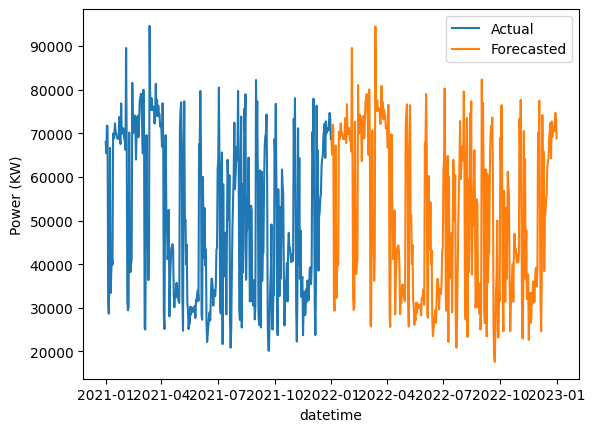

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
df_daily = df_daily.reset_index()
df_forecasted_daily = pd.read_csv(r'C:/Advance Substation Forecasting/power_consumption_forecast_daily.csv')
df_forecasted_daily['datetime'] = pd.to_datetime(df_forecasted_daily['datetime'], format='%Y-%m-%d')
# Plot POWER (KW) column from both files
plt.plot(df_daily['datetime_new'], df_daily['POWER (KW)'], label='Actual')
plt.plot(df_forecasted_daily['datetime'], df_forecasted_daily['POWER (KW)'], label='Forecasted')

# Set axis labels and legend
plt.xlabel('datetime')
plt.ylabel('Power (KW)')
plt.legend()

# Show the plot
plt.show()

# Feature Extraction, Model Testing and Forecasting for Weekly Interval

In [52]:
df_weekly = df.resample('W', on='datetime_new').sum()
feature_subsets = [['VOLTAGE'], ['VOLTAGE', 'CURRENT'], ['VOLTAGE', 'CURRENT', 'PF'], ['VOLTAGE', 'CURRENT', 'PF', 'Temp (F)'],
                  ['VOLTAGE', 'CURRENT', 'PF', 'Temp (F)', 'Humidity (%)']]

# initialize the list to store the MSE values for each feature subset
mse_values = []

# loop through the feature subsets and evaluate the performance of the model with each subset
for features in feature_subsets:
    # create the feature matrix X and the target variable y
    X = df_weekly[features]
    y = df_weekly['POWER (KW)']

    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # initialize the random forest regressor
    rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)

    # fit the regressor to the training data
    rf_reg.fit(X_train, y_train)

    # predict the target variable for the testing data
    y_pred = rf_reg.predict(X_test)

    # calculate the MSE value for the current feature subset
    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)

# print the MSE values for each feature subset
print("MSE values:", mse_values)

# find the index of the feature subset with the lowest MSE value
min_mse_index = mse_values.index(min(mse_values))

# get the corresponding feature subset
selected_features = feature_subsets[min_mse_index]

print("Selected features:", selected_features)

MSE values: [18800668868.001957, 217507257.0912636, 159502913.86841816, 177592672.17212716, 194360473.1684634]
Selected features: ['VOLTAGE', 'CURRENT', 'PF']


In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Set up data
train_data, test_data = train_test_split(df_weekly, test_size=0.2, shuffle=False)

# Set up exogenous variables
exog_train = train_data[['VOLTAGE', 'CURRENT', 'PF']]
exog_test = test_data[['VOLTAGE', 'CURRENT', 'PF']]

# Set up endogenous variable
endog_train = train_data['POWER (KW)']
endog_test = test_data['POWER (KW)']

# Set up linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(exog_train, endog_train)

# Predict on the test data
forecast = model.predict(exog_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(endog_test, forecast))
print(f"RMSE: {rmse}")

# Calculate evaluation metrics
mse = mean_squared_error(endog_test, forecast)
mae = mean_absolute_error(endog_test, forecast)
r2 = r2_score(endog_test, forecast)
mape = round(np.mean(abs((endog_test - forecast) / endog_test)) * 100, 4)
smape = round(np.mean(2 * abs(forecast - endog_test) / (abs(forecast) + abs(endog_test))) * 100, 4)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Symmetric Mean Absolute Percentage Error (SMAPE):", smape)

RMSE: 4076.7177068305573
Mean Squared Error (MSE): 16619627.261185797
Mean Absolute Error (MAE): 3026.0796673628847
R-squared (R2) Score: 0.9971088922613219
Mean Absolute Percentage Error (MAPE): 1.0051
Symmetric Mean Absolute Percentage Error (SMAPE): 1.0147


In [54]:
from sklearn.linear_model import LinearRegression

# Set up data
train_size = int(len(df_weekly) * 0.8)
train_data = df_weekly[:train_size]
test_data = df_weekly[train_size:]

# Set up features and target variables
features = ['VOLTAGE', 'CURRENT', 'PF']
target = ['POWER (KW)']

# Set up exogenous variables
exog_train = train_data[features]
exog_test = test_data[features]

# Set up endogenous variable
endog_train = train_data[target]
endog_test = test_data[target]

# Set up linear regression model
model = LinearRegression()

# Train linear regression model
model.fit(exog_train, endog_train)

# Forecast on test data
forecast_weekly = model.predict(exog_test)


# Print forecasted values
print("Forecasted values:")
print(forecast_weekly)

Forecasted values:
[[268030.20230468]
 [295525.67001715]
 [355251.89947515]
 [324675.4307074 ]
 [205822.21754482]
 [247689.08455395]
 [372785.61925724]
 [336356.70359777]
 [425585.16486355]
 [498615.7184789 ]
 [362528.07581305]]


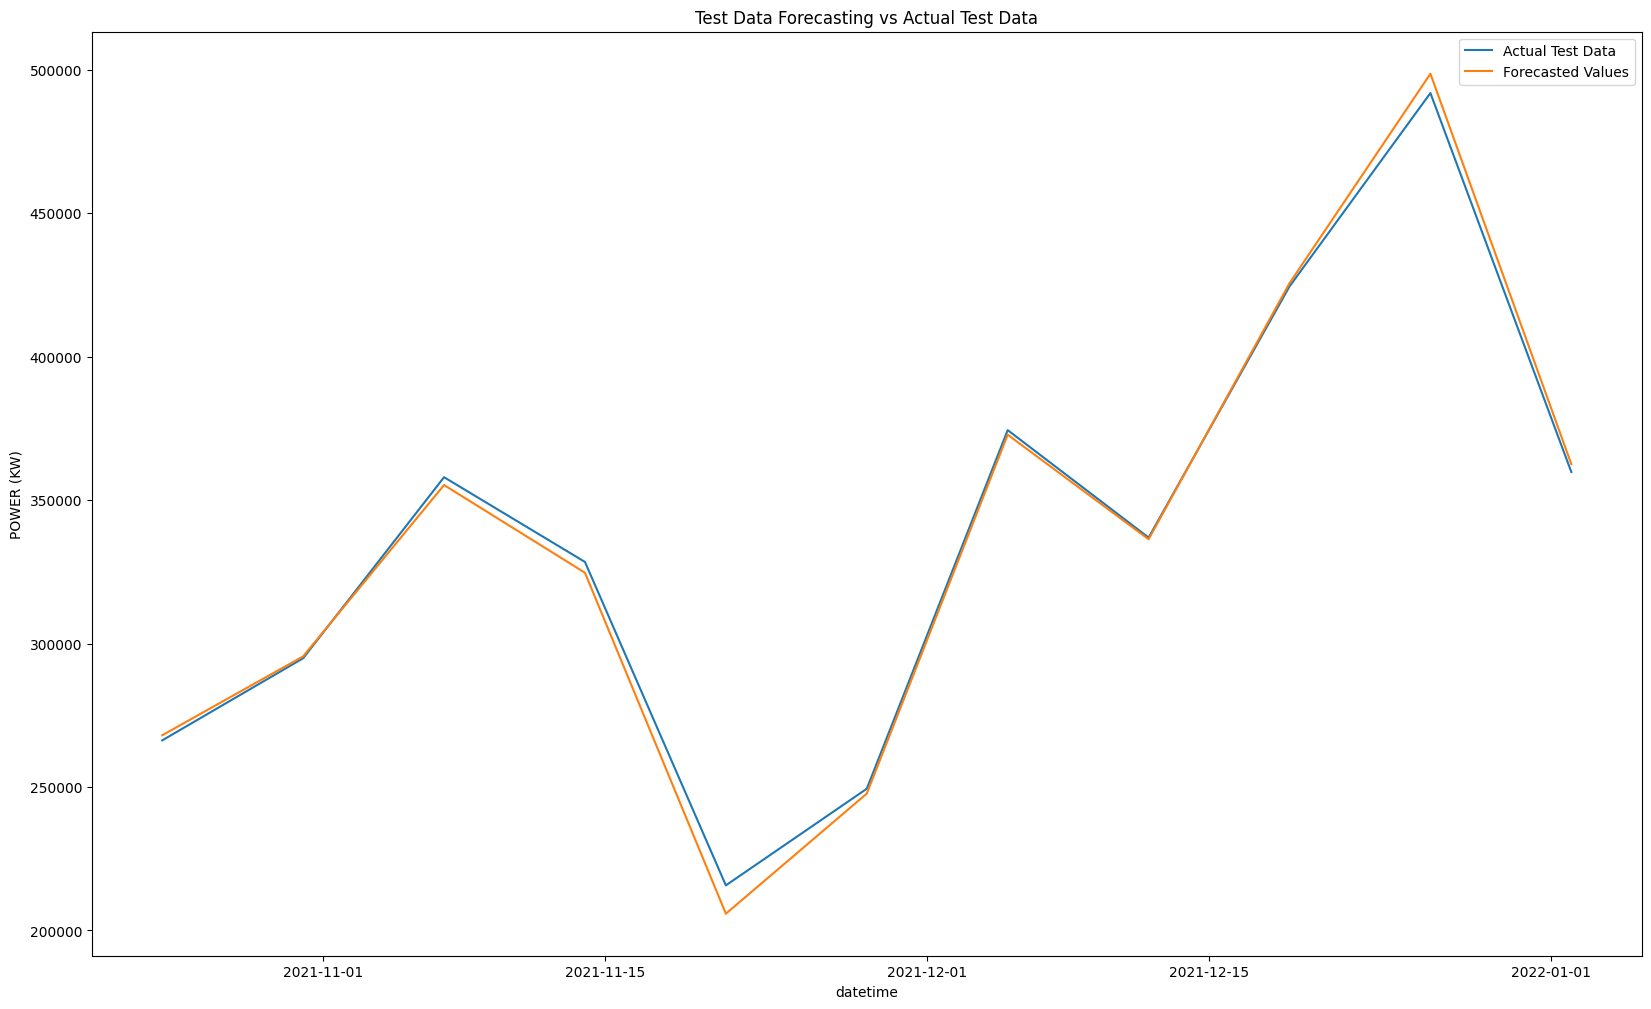

In [55]:
import matplotlib.pyplot as plt

# Assuming test data is in a DataFrame called "test_data" with the actual values in a column named "POWER (KW)"

# Convert forecast NumPy array to Pandas Series
forecast_series = pd.Series(forecast_weekly.flatten(), index=test_data.index)

# Extract the forecasted values from the Series
forecasted_values = forecast_series.values

# Extract the index from the test data for x-axis
x_axis = test_data.index

# Plot the actual test data and forecasted values
plt.figure(figsize=(20, 12))
plt.plot(x_axis, endog_test, label='Actual Test Data')
plt.plot(x_axis, forecasted_values, label='Forecasted Values')
plt.xlabel('datetime')
plt.ylabel('POWER (KW)')
plt.title('Test Data Forecasting vs Actual Test Data')
plt.legend()
plt.show()

In [56]:
from sklearn.linear_model import LinearRegression

# Set up data
train_data = df_weekly

# Set up exogenous variables
exog_train = train_data[['VOLTAGE', 'CURRENT', 'PF']]

# Set up endogenous variable
endog_train = train_data['POWER (KW)']

# Set up linear regression model
model = LinearRegression()
model.fit(exog_train, endog_train)

# forecast next 1 year
exog_forecast = exog_train[-52:]
forecast_weekly = model.predict(exog_forecast)

# print forecast
print("Forecasted power consumption (KW) for the next 1 year:")
print(forecast_weekly)

Forecasted power consumption (KW) for the next 1 year:
[305210.35538363 432242.47296426 485739.08265309 490030.4643278
 377267.32664534 389321.28198981 494670.98533586 526979.56014793
 379132.90894717 412129.26308346 526518.75687381 530657.27157314
 499654.51766303 323424.72356791 287281.10577069 256857.48403575
 309394.05310332 386410.26045213 249042.61843846 205466.7299016
 226194.05451942 366259.65437474 319206.95398205 197845.59847859
 241268.07719332 386668.05089563 305826.76881436 337992.00450433
 270097.24435179 445330.82460255 397619.61840993 386059.32651881
 339531.56623649 266802.3172925  366575.28053752 310496.77730977
 458514.27549688 209059.51030381 319407.94929169 301881.34790955
 315838.88285091 268544.52419441 295947.60827471 355240.46180245
 325189.54856886 207193.09790551 248417.79702958 372681.49732299
 336634.51983097 425112.829438   497712.31236525 361529.16732763]


In [57]:
# create date range starting from 2022-01-01
date_rng = pd.date_range(start='2022-01-01', end='2022-12-31', freq='W')

# create dataframe of forecast results
forecast_df_weekly = pd.DataFrame({'datetime': date_rng, 'POWER (KW)': forecast_weekly})

# save forecast results to csv file
forecast_df_weekly.to_csv('C:/Advance Substation Forecasting/power_consumption_forecast_weekly.csv', index=False)

print("Forecast saved to power_consumption_forecast_weekly.csv")

Forecast saved to power_consumption_forecast_weekly.csv


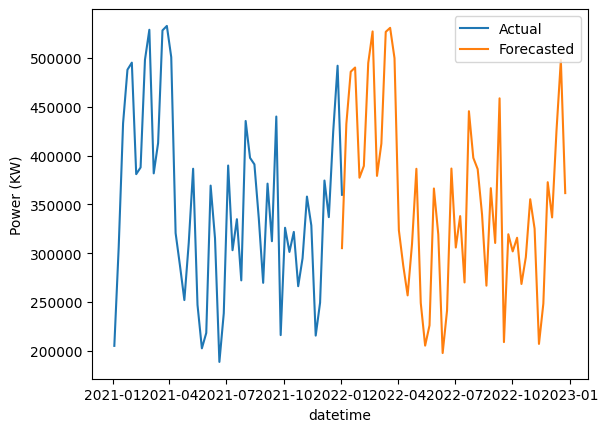

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
df_weekly = df_weekly.reset_index()
df_forecasted_weekly = pd.read_csv(r'C:/Advance Substation Forecasting/power_consumption_forecast_weekly.csv')
df_forecasted_weekly['datetime'] = pd.to_datetime(df_forecasted_weekly['datetime'], format='%Y-%m-%d')
# Plot POWER (KW) column from both files
plt.plot(df_weekly['datetime_new'], df_weekly['POWER (KW)'], label='Actual')
plt.plot(df_forecasted_weekly['datetime'], df_forecasted_weekly['POWER (KW)'], label='Forecasted')

# Set axis labels and legend
plt.xlabel('datetime')
plt.ylabel('Power (KW)')
plt.legend()

# Show the plot
plt.show()

# Feature Extraction, Model Testing and Forecasting for Monthly Interval

In [59]:
df_monthly = df.resample('M', on='datetime_new').sum()
feature_subsets = [['VOLTAGE'], ['VOLTAGE', 'CURRENT'], ['VOLTAGE', 'CURRENT', 'PF'], ['VOLTAGE', 'CURRENT', 'PF', 'Temp (F)'],
                  ['VOLTAGE', 'CURRENT', 'PF', 'Temp (F)', 'Humidity (%)']]

# initialize the list to store the MSE values for each feature subset
mse_values = []

# loop through the feature subsets and evaluate the performance of the model with each subset
for features in feature_subsets:
    # create the feature matrix X and the target variable y
    X = df_monthly[features]
    y = df_monthly['POWER (KW)']

    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # initialize the random forest regressor
    rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)

    # fit the regressor to the training data
    rf_reg.fit(X_train, y_train)

    # predict the target variable for the testing data
    y_pred = rf_reg.predict(X_test)

    # calculate the MSE value for the current feature subset
    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)

# print the MSE values for each feature subset
print("MSE values:", mse_values)

# find the index of the feature subset with the lowest MSE value
min_mse_index = mse_values.index(min(mse_values))

# get the corresponding feature subset
selected_features = feature_subsets[min_mse_index]

print("Selected features:", selected_features)

MSE values: [187198206966.5048, 737018760.9867023, 1202564268.2113643, 4535359680.5591, 12083642702.943932]
Selected features: ['VOLTAGE', 'CURRENT']


In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Set up data
train_data, test_data = train_test_split(df_monthly, test_size=0.2, shuffle=False)

# Set up exogenous variables
exog_train = train_data[['VOLTAGE', 'CURRENT']]
exog_test = test_data[['VOLTAGE', 'CURRENT']]

# Set up endogenous variable
endog_train = train_data['POWER (KW)']
endog_test = test_data['POWER (KW)']

# Set up linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(exog_train, endog_train)

# Predict on the test data
forecast = model.predict(exog_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(endog_test, forecast))
print(f"RMSE: {rmse}")

# Calculate evaluation metrics
mse = mean_squared_error(endog_test, forecast)
mae = mean_absolute_error(endog_test, forecast)
r2 = r2_score(endog_test, forecast)
mape = round(np.mean(abs((endog_test - forecast) / endog_test)) * 100, 4)
smape = round(np.mean(2 * abs(forecast - endog_test) / (abs(forecast) + abs(endog_test))) * 100, 4)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Symmetric Mean Absolute Percentage Error (SMAPE):", smape)

RMSE: 27023.679559365268
Mean Squared Error (MSE): 730279256.9272562
Mean Absolute Error (MAE): 25540.161037770566
R-squared (R2) Score: 0.9914359753982123
Mean Absolute Percentage Error (MAPE): 1.684
Symmetric Mean Absolute Percentage Error (SMAPE): 1.6998


In [61]:
from sklearn.linear_model import LinearRegression

# Set up data
train_size = int(len(df_monthly) * 0.8)
train_data = df_monthly[:train_size]
test_data = df_monthly[train_size:]

# Set up features and target variables
features = ['VOLTAGE', 'CURRENT']
target = ['POWER (KW)']

# Set up exogenous variables
exog_train = train_data[features]
exog_test = test_data[features]

# Set up endogenous variable
endog_train = train_data[target]
endog_test = test_data[target]

# Set up linear regression model
model = LinearRegression()

# Train linear regression model
model.fit(exog_train, endog_train)

# Forecast on test data
forecast_monthly = model.predict(exog_test)


# Print forecasted values
print("Forecasted values:")
print(forecast_monthly)

Forecasted values:
[[1360430.71703855]
 [1213151.10723199]
 [1882969.69261614]]


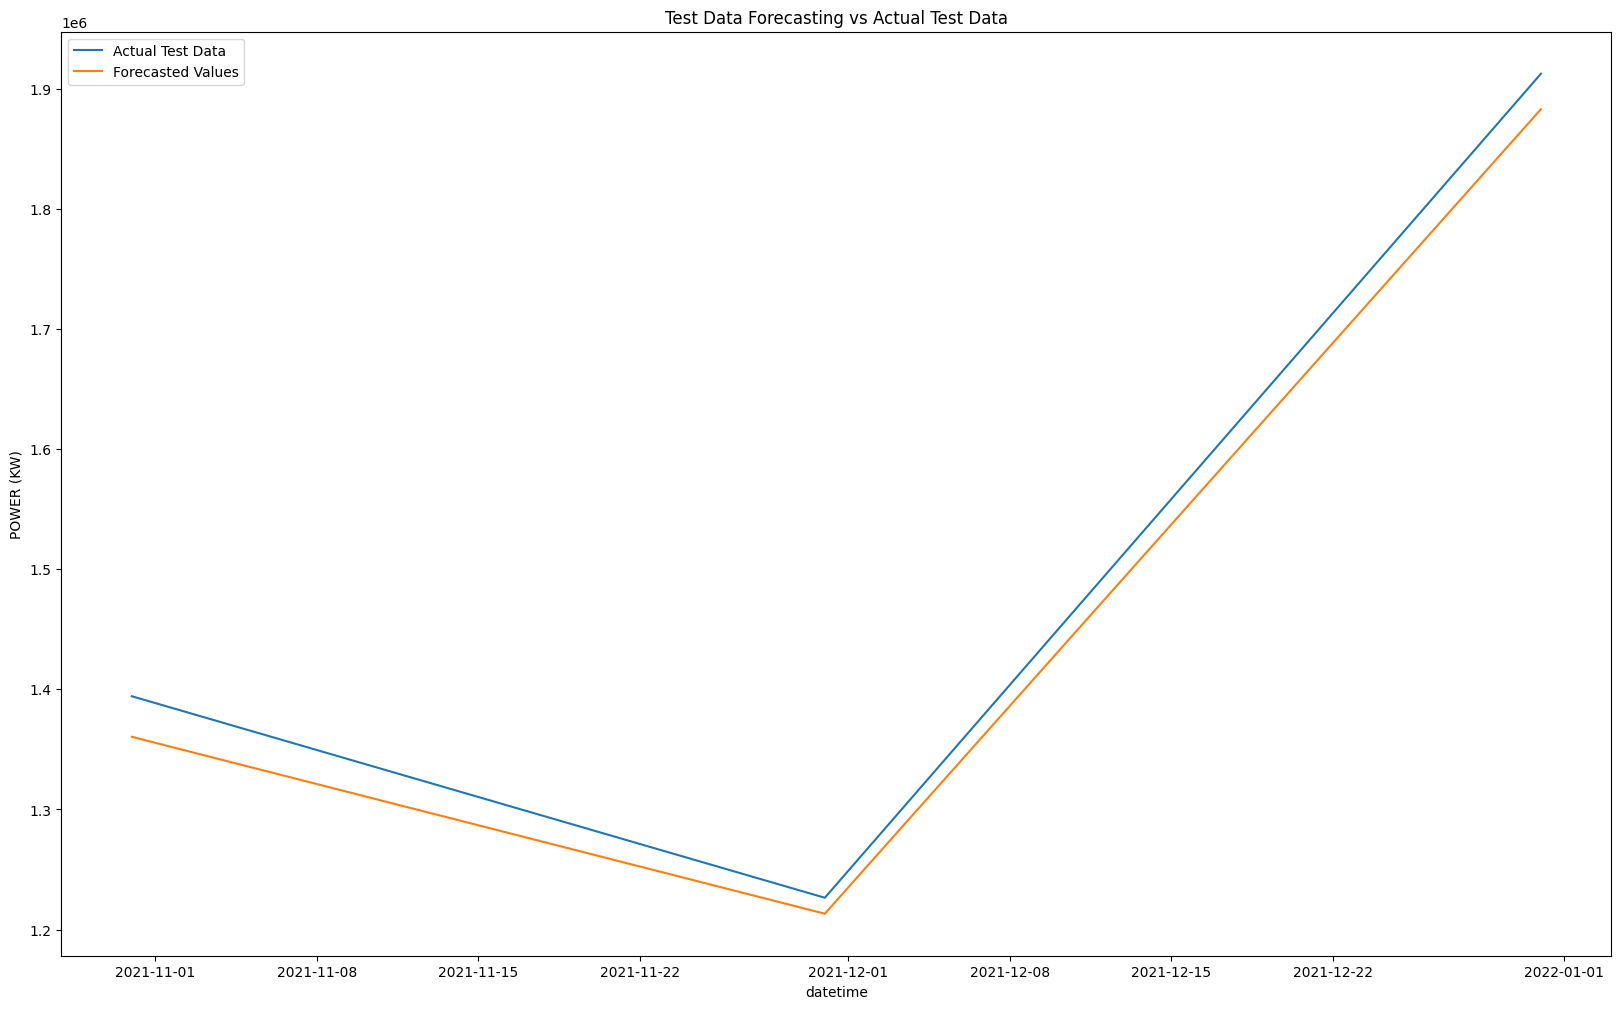

In [62]:
import matplotlib.pyplot as plt

# Assuming test data is in a DataFrame called "test_data" with the actual values in a column named "POWER (KW)"

# Convert forecast NumPy array to Pandas Series
forecast_series = pd.Series(forecast_monthly.flatten(), index=test_data.index)

# Extract the forecasted values from the Series
forecasted_values = forecast_series.values

# Extract the index from the test data for x-axis
x_axis = test_data.index

# Plot the actual test data and forecasted values
plt.figure(figsize=(20, 12))
plt.plot(x_axis, endog_test, label='Actual Test Data')
plt.plot(x_axis, forecasted_values, label='Forecasted Values')
plt.xlabel('datetime')
plt.ylabel('POWER (KW)')
plt.title('Test Data Forecasting vs Actual Test Data')
plt.legend()
plt.show()

In [63]:
from sklearn.linear_model import LinearRegression

# Set up data
train_data = df_monthly

# Set up exogenous variables
exog_train = train_data[['VOLTAGE', 'CURRENT']]

# Set up endogenous variable
endog_train = train_data['POWER (KW)']

# Set up linear regression model
model = LinearRegression()
model.fit(exog_train, endog_train)

# forecast next 1 year
exog_forecast = exog_train[-12:]
forecast_monthly = model.predict(exog_forecast)

# print forecast
print("Forecasted power consumption (KW) for the next 1 year:")
print(forecast_monthly)

Forecasted power consumption (KW) for the next 1 year:
[1896061.99291012 1772553.12845188 2057751.77688521 1313065.31134683
 1188080.22404468 1175521.1675119  1562814.1633186  1606465.82401699
 1482726.30420576 1368980.06155121 1218646.55702566 1890602.48873117]


In [64]:
# create date range starting from 2022-01-01
date_rng = pd.date_range(start='2022-01-01', end='2022-12-31', freq='M')

# create dataframe of forecast results
forecast_df_monthly = pd.DataFrame({'datetime': date_rng, 'POWER (KW)': forecast_monthly})

# save forecast results to csv file
forecast_df_monthly.to_csv('C:/Advance Substation Forecasting/power_consumption_forecast_monthly.csv', index=False)

print("Forecast saved to power_consumption_forecast_monthly.csv")

Forecast saved to power_consumption_forecast_monthly.csv


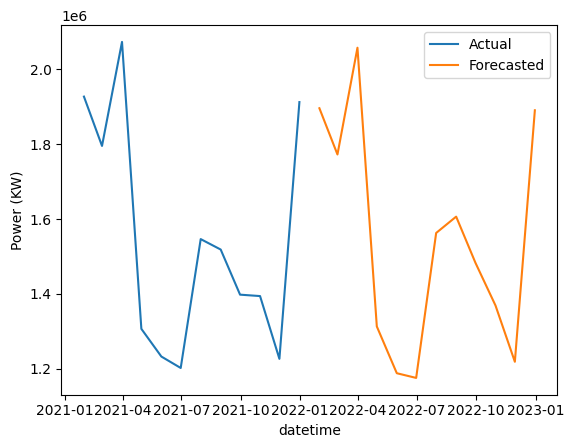

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
df_monthly = df_monthly.reset_index()
df_forecasted_monthly = pd.read_csv(r'C:/Advance Substation Forecasting/power_consumption_forecast_monthly.csv')
df_forecasted_monthly['datetime'] = pd.to_datetime(df_forecasted_monthly['datetime'], format='%Y-%m-%d')
# Plot POWER (KW) column from both files
plt.plot(df_monthly['datetime_new'], df_monthly['POWER (KW)'], label='Actual')
plt.plot(df_forecasted_monthly['datetime'], df_forecasted_monthly['POWER (KW)'], label='Forecasted')

# Set axis labels and legend
plt.xlabel('datetime')
plt.ylabel('Power (KW)')
plt.legend()

# Show the plot
plt.show()